# Inteligencia Artificial 2
## P1 Project: Implement a Recommender system using a bipartite network projection
### Autores: Miguel Brito, Diana Cuenca, José Escudero, Danny Huacon, Steveen Terán

## Importar y analizar datos
1. Importar librerías

In [2]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


2. Importar datos

In [3]:
electronics_data = pd.read_csv("./ratings_electronics.csv", names=['userId', 'productId', 'Rating', 'timestamp'])
electronics_data.drop(['timestamp'], axis=1,inplace=True)
electronics_data.head()


,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


3. Analizar rango de ratings y revisar integridad de datos

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))
print("=====================================================================================================")
print('Number of missing values across columns: \n',electronics_data.isnull().sum())


4. Graficar distribucion de ratings

In [ ]:
# Check the distribution of the rating

# create a dictionary in which the key is the rating, and the value is the number of times that rating occurs
rating_distribution = electronics_data.groupby(['Rating'])['Rating'].agg(['count'])
sns.barplot(x=rating_distribution.index, y=rating_distribution['count'])


5. Imprimir cantidad de ratings, usuarios unicos y productos unicos

In [ ]:
print("Total no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))


## Desarrollo de taller

1. Generar red bipartita

En versiones anteriores de networkX se hubiera utilizado el metodo `from_pandas_dataframe`.\
Sin embargo, este metodo ha sido deprecado y se recomienda utilizar `from_pandas_edgelist` en su lugar.

Fuente: `https://stackoverflow.com/a/49580740`

In [54]:
import networkx as nx
from networkx.algorithms import bipartite
from operator import itemgetter

# Filtrar las revisiones con 5 estrellas
five_star_reviews = electronics_data[electronics_data['Rating'] == 5]

# Crear el grafo bipartito
B = nx.from_pandas_edgelist(five_star_reviews, 'userId', 'productId', edge_attr=None, create_using=None)

# Assign label to nodes
unique_user_ids = set(electronics_data['userId'])
for node in B.nodes():
    if node in unique_user_ids:
        B.nodes[node]['bipartite'] = 'users'
    else:
        B.nodes[node]['bipartite'] = 'products'

# Confirmar que es bipartito
bipartite.is_bipartite(B)


True

2.a Ejemplo de sistema de recomendacion con datos de la red bipartita. \
   En este bloque se selecciona un usuario, y se obtiene los productos revisados por otros usuarios que han revisado los mismos productos que el usuario en cuestión

In [30]:
from itertools import chain

# Obtener un usuario del dataframe
user_node = five_star_reviews.iloc[0]['userId']

# Obtener los productos que ha revisado este usuario
products_reviewed_by_user = B.neighbors(user_node)

# Obtener los usuarios que han hecho review de los mismos productos que el usuario en cuestión
related_users = list(bipartite.weighted_projected_graph(B, [user_node]))

# Obtener los productos que han sido revisados por los usuarios relacionados
recommendations = chain.from_iterable([list(B.neighbors(node)) for node in related_users])

# Eliminar los productos que ya ha revisado el usuario en cuestión
recommendations = set(recommendations) - set(products_reviewed_by_user)

recommendations


{'B00005LEOM',
 'B000J3ZGXY',
 'B000JSS8NE',
 'B0012Y6HC8',
 'B002Q5NKYK',
 'B003G2YZ8M',
 'B004DOUOI2',
 'B004LNXO28',
 'B004USLWVE',
 'B004Y1AYAC',
 'B00668G1H6',
 'B006W8U2MU',
 'B007OUIL1Y',
 'B0083WYFWG'}

2.b Ejemplo de sistema de recomendacion con datos de la red bipartita. \
   En este bloque se ordena los productos obtenidos en el bloque anterior, de acuerdo a la cantidad de usuarios que han revisado el producto, y se selecciona los 10 productos con mayor cantidad de usuarios que lo han revisado

In [44]:
product_recommendation_counts = [(product, B.degree(product)) for product in recommendations]
top_recommended_products = sorted(product_recommendation_counts, key=itemgetter(1), reverse=True)[:10]
for product, count in top_recommended_products:
    print(f"Producto: {product}, revisado por: {count} usuarios")


Producto: B006W8U2MU, revisado por: 2645 usuarios
Producto: B004LNXO28, revisado por: 970 usuarios
Producto: B0012Y6HC8, revisado por: 652 usuarios
Producto: B004Y1AYAC, revisado por: 481 usuarios
Producto: B0083WYFWG, revisado por: 134 usuarios
Producto: B007OUIL1Y, revisado por: 82 usuarios
Producto: B000J3ZGXY, revisado por: 38 usuarios
Producto: B004DOUOI2, revisado por: 36 usuarios
Producto: B002Q5NKYK, revisado por: 34 usuarios
Producto: B00005LEOM, revisado por: 30 usuarios


3.a Se crea un subconjunto de datos para construir un grafo bipartita para imprimir. \
    En este bloque se arma el grafo con un conjunto de 100 datos.

In [55]:
# Si deseas visualizar una parte del gráfico:
subset_data = five_star_reviews.head(100)

B_sub = nx.from_pandas_edgelist(subset_data, 'userId', 'productId', edge_attr=None, create_using=None)
# Assign label to nodes
unique_user_ids = set(electronics_data['userId'])
for node in B_sub.nodes():
    if node in unique_user_ids:
        B_sub.nodes[node]['bipartite'] = 'users'
    else:
        B_sub.nodes[node]['bipartite'] = 'products'

# Confirmar que es bipartito
bipartite.is_bipartite(B)


True

3.b Se crea un subconjunto de datos para construir un grafo bipartita para imprimir. \
    En este bloque se imprimie el grafo bipartita generado en el bloque anterior.

<Figure size 1200x1200 with 0 Axes>

Text(0.5, 1.0, 'Subset of Bipartite User-Product Network')

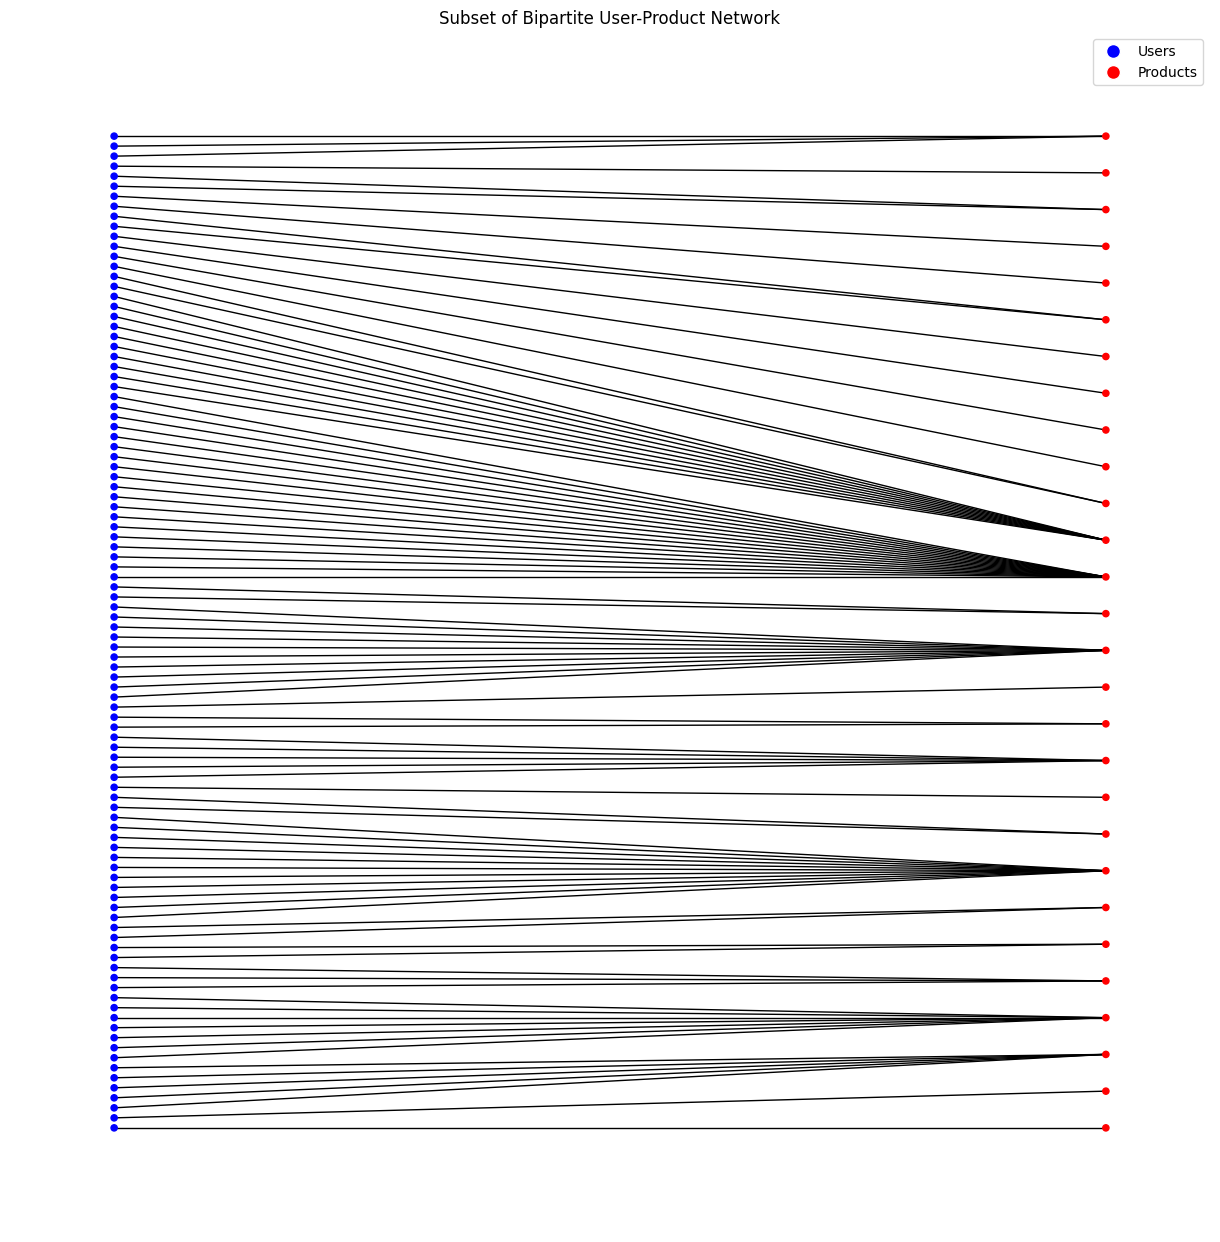

In [57]:

# Dibujar el grafo
pos = nx.bipartite_layout(B_sub, nodes=[n for n, d in B_sub.nodes(data=True) if d['bipartite'] == 'users'])
colors = ["blue" if d['bipartite'] == 'users' else "red" for n, d in B_sub.nodes(data=True)]

plt.figure(figsize=(12, 12))
nx.draw(B_sub, pos=pos, node_color=colors, with_labels=False, node_size=20)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Users', markersize=10, markerfacecolor='blue')
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Products', markersize=10, markerfacecolor='red')
plt.legend(handles=[blue_patch, red_patch])
plt.title("Subset of Bipartite User-Product Network")
plt.show()


4. Poda de grafo bipartito e impresión del mismo

4.a Mostrar usuarios con mas de 250 reviews

El grafo podado tiene 4 usuarios y 1076 productos


<Figure size 1200x1200 with 0 Axes>

Text(0.5, 1.0, 'Subconjunto del Grafo Bipartito Usuarios-Productos después de la poda')

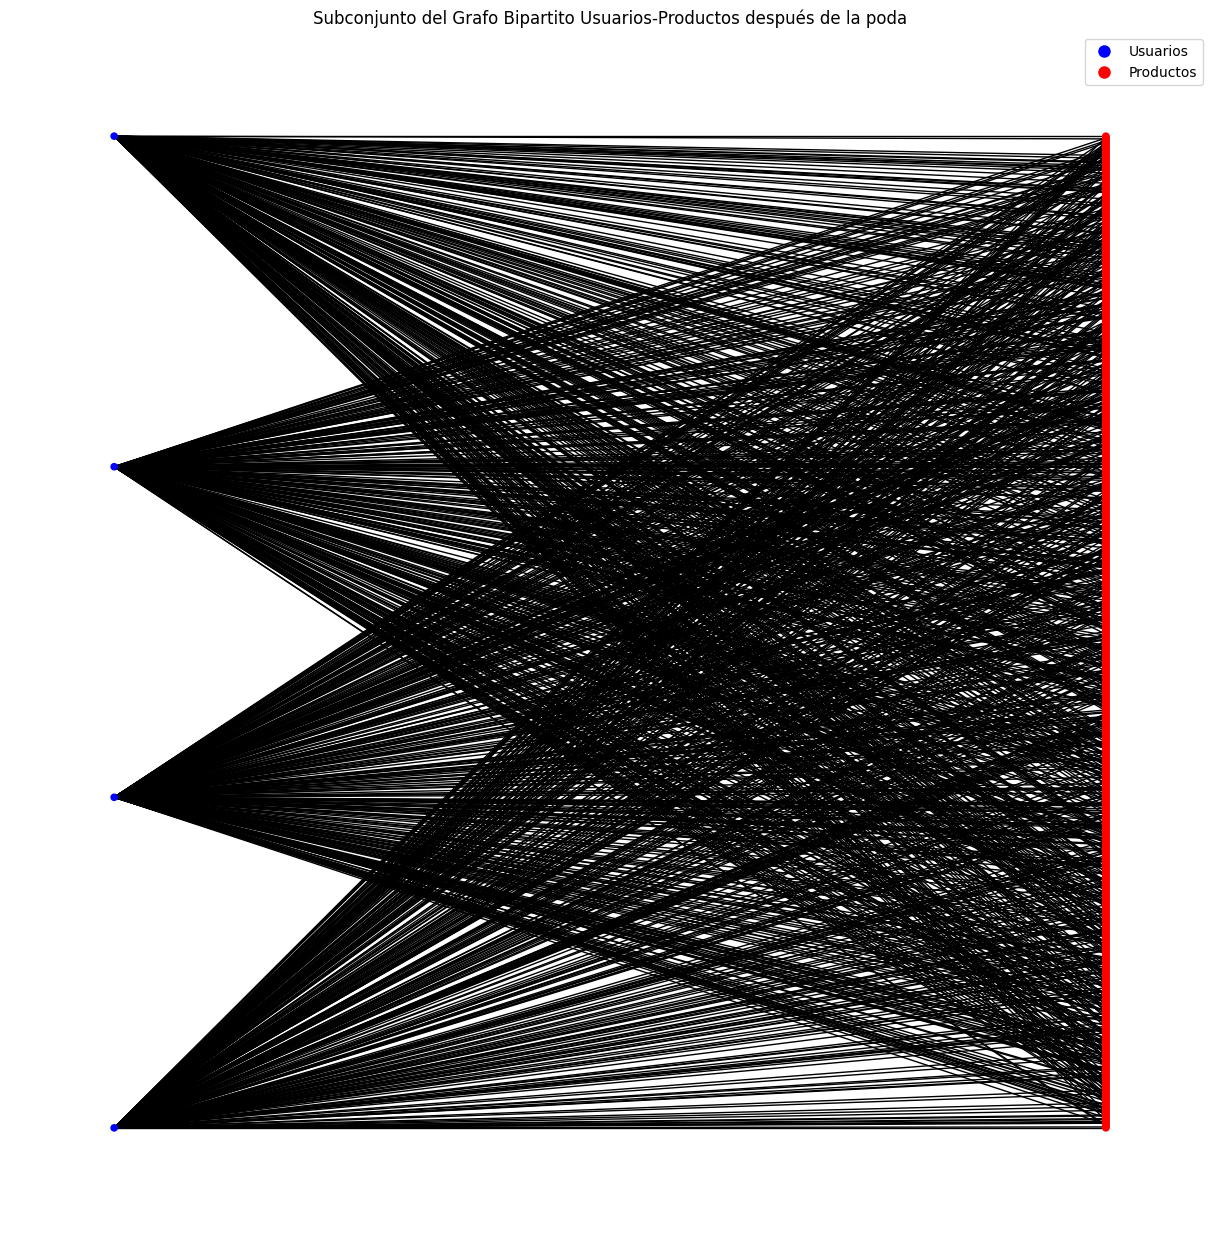

In [80]:
degree_threshold = 250  # por ejemplo, solo conservar nodos con grado > 5
users_nodes_to_remove = [node for node, data in B.nodes(data=True) if data['bipartite'] == 'users' and B.degree(node) < degree_threshold]
trimmed_B = B.subgraph(B.nodes - set(users_nodes_to_remove))

orphan_products_nodes = [node for node, data in trimmed_B.nodes(data=True) if data['bipartite'] == 'products' and trimmed_B.degree(node) == 0]
trimmed_B = trimmed_B.subgraph(trimmed_B.nodes - set(orphan_products_nodes))


users_count = len([node for node, data in trimmed_B.nodes(data=True) if data['bipartite'] == 'users'])
products_count = len([node for node, data in trimmed_B.nodes(data=True) if data['bipartite'] == 'products'])

print(f"El grafo podado tiene {users_count} usuarios y {products_count} productos")

# Dibujar el grafo
pos = nx.bipartite_layout(trimmed_B, nodes=[n for n, d in trimmed_B.nodes(data=True) if d['bipartite'] == 'users'])
colors = ["blue" if d['bipartite'] == 'users' else "red" for n, d in trimmed_B.nodes(data=True)]

plt.figure(figsize=(12, 12))
nx.draw(trimmed_B, pos=pos, node_color=colors, with_labels=False, node_size=20)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Usuarios', markersize=10, markerfacecolor='blue')
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Productos', markersize=10, markerfacecolor='red')
plt.legend(handles=[blue_patch, red_patch])
plt.title("Subconjunto del Grafo Bipartito Usuarios-Productos después de la poda")
plt.show()


4b. Mostrar productos con mas de 10,000 reviews

El grafo podado tiene 133967 usuarios y 20 productos


<Figure size 1200x1200 with 0 Axes>

Text(0.5, 1.0, 'Subconjunto del Grafo Bipartito Usuarios-Productos después de la poda')

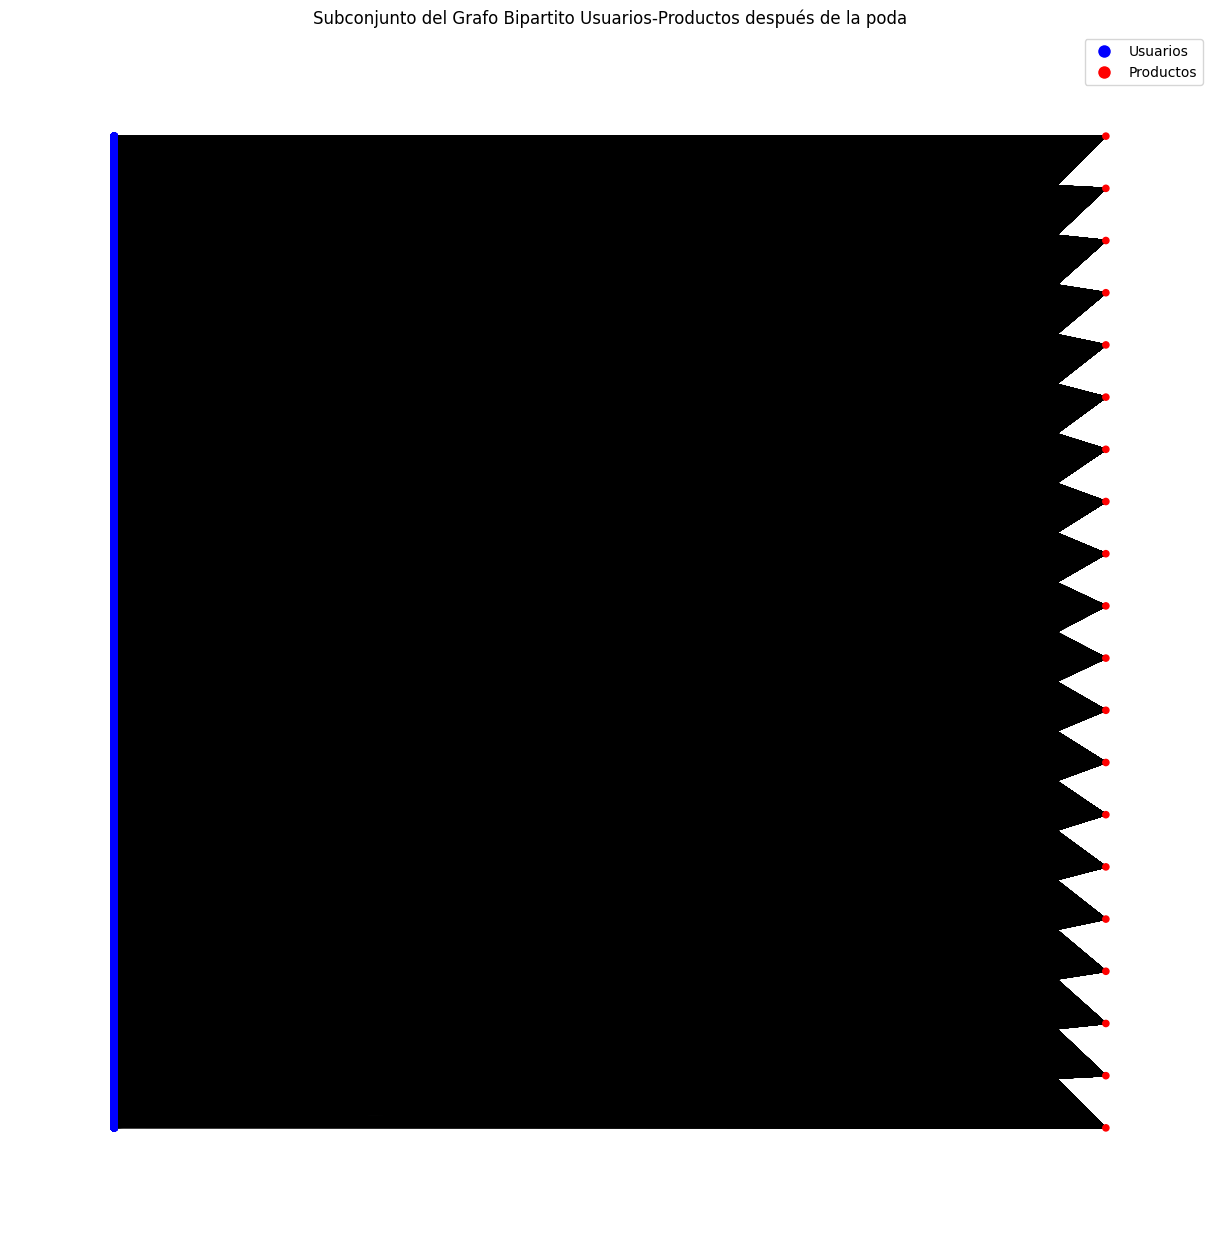

In [84]:
degree_threshold = 10000  # por ejemplo, solo conservar nodos con grado > 5
product_nodes_to_remove = [node for node, data in B.nodes(data=True) if data['bipartite'] == 'products' and B.degree(node) < degree_threshold]
trimmed_B = B.subgraph(B.nodes - set(product_nodes_to_remove))

orphan_user_nodes = [node for node, data in trimmed_B.nodes(data=True) if data['bipartite'] == 'users' and trimmed_B.degree(node) == 0]
trimmed_B = trimmed_B.subgraph(trimmed_B.nodes - set(orphan_user_nodes))


users_count = len([node for node, data in trimmed_B.nodes(data=True) if data['bipartite'] == 'users'])
products_count = len([node for node, data in trimmed_B.nodes(data=True) if data['bipartite'] == 'products'])

print(f"El grafo podado tiene {users_count} usuarios y {products_count} productos")

# Dibujar el grafo
pos = nx.bipartite_layout(trimmed_B, nodes=[n for n, d in trimmed_B.nodes(data=True) if d['bipartite'] == 'users'])
colors = ["blue" if d['bipartite'] == 'users' else "red" for n, d in trimmed_B.nodes(data=True)]

plt.figure(figsize=(12, 12))
nx.draw(trimmed_B, pos=pos, node_color=colors, with_labels=False, node_size=20)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Usuarios', markersize=10, markerfacecolor='blue')
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Productos', markersize=10, markerfacecolor='red')
plt.legend(handles=[blue_patch, red_patch])
plt.title("Subconjunto del Grafo Bipartito Usuarios-Productos después de la poda")
plt.show()


## Funcion de recomendaciones e interfaz

In [103]:
def get_product_recommendation_network(product, limit):
  recommended_products = set(bipartite.weighted_projected_graph(B, [product])) - set([product])
  recommended_products_with_weight = [(recommended_product, B.degree(recommended_product)) for recommended_product in recommended_products]

  top_recommendations = sorted(recommended_products_with_weight, key=lambda x: -x[1])[:limit]

  # create a networkX graph, in which the product is the center node, and the recommended products are the neighbors.
  # use weighted edges to indicate how many users have bought both products
  G = nx.Graph()
  G.add_node(product)
  for recommended_product, weight in top_recommendations:
    G.add_node(recommended_product)
    G.add_edge(product, recommended_product, weight=weight)

  return G



Dropdown(description='Product ID:', options=('0132793040', '0321732944', '0511189877', '0528881469', '05940023…

Dropdown(description='N recommendations:', index=4, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=5)

Button(description='Consultar', icon='check', style=ButtonStyle(), tooltip='Click me')

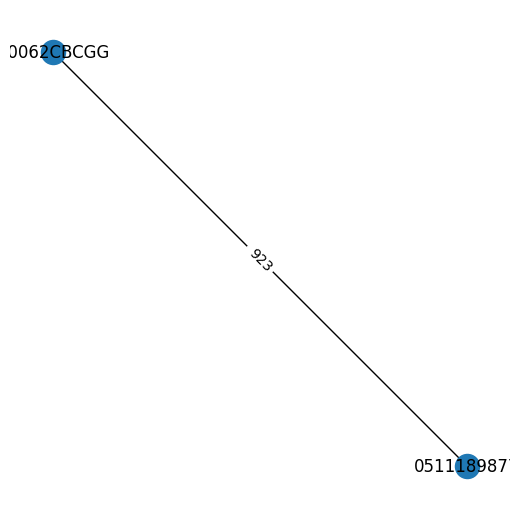

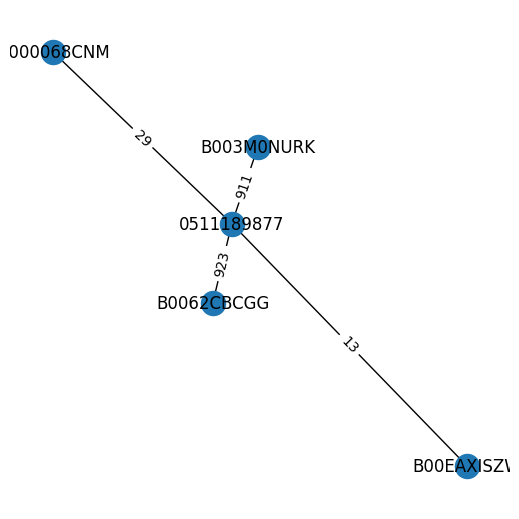

In [108]:
import ipywidgets as widgets

def query(btn):
    product_id = product_id_widget.value
    n_limit = n_limit_widget.value
    recommendation_network = get_product_recommendation_network(product_id, n_limit)
    # plot the network, and show the edge weights
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(recommendation_network)
    nx.draw(recommendation_network, pos=pos, with_labels=True)
    edge_labels = nx.get_edge_attributes(recommendation_network, 'weight')
    nx.draw_networkx_edge_labels(recommendation_network, pos=pos, edge_labels=edge_labels)
    plt.show()


# Get nodes from B that are partite == 1 (products)
product_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 'products'][:1000]

product_id_widget = widgets.Dropdown(
    options=product_nodes,
    value=product_nodes[0],
    description='Product ID:',
    disabled=False,
)
n_limit_widget = widgets.Dropdown(
    options=list(range(1,11)),
    value=5,
    description='N recommendations:',
    disabled=False,
)

button = widgets.Button(
    description='Consultar',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

button.on_click(query)

product_id_widget
n_limit_widget
button
